In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.stats import norm

# R1.2: **Single product and stochastic environment**:  BUDGET

### BUYER: Users

In [7]:
class Buyer:
  def __init__(self, mu=0.5, sigma=1.0):
    """
    Represents a single buyer that draws a new valuation at each round.
    :param value_distribution: Tuple defining the support of the uniform distribution.
    """
    self.mu = mu
    self.sigma = sigma

  def round(self, price):
    """
    Generates a random valuation and decides whether to buy at the given price.
    :param price: Offered price
    :return: Reward (price if buyer accepts, 0 otherwise)
    """
    valuation = np.random.normal(self.mu, self.sigma)
    return 1 if price < valuation else 0

COMPANY
----

multiple ptoducts

In [8]:
class CompanyUCB1_V2:
  def __init__(self, K, B, T, range=1):
    self.K = K
    self.T = T
    self.range = range
    self.p_t = None # it's an index, not the actual bid
    self.avg_f = np.zeros(K)
    self.avg_c = np.zeros(K)
    self.N_pulls = np.zeros(K)
    self.budget = B
    self.rho = B/T
    self.t = 0

  def pull_arm(self):
    if self.budget < 1:
      self.p_t = 0
      return 0
    if self.t < self.K:
      self.p_t = self.t
    else:
      f_ucbs = self.avg_f + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
      c_lcbs = self.avg_c - self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
      gammp_t = self.compute_opt(f_ucbs, c_lcbs)
      self.p_t = np.random.choice(self.K, p=gammp_t)
    return self.p_t

  def compute_opt(self, f_ucbs, c_lcbs):
    if np.sum(c_lcbs <= np.zeros(len(c_lcbs))):
      gamma = np.zeros(len(f_ucbs))
      gamma[np.argmax(f_ucbs)] = 1
      return gamma
    c = -f_ucbs
    A_ub = [c_lcbs]
    b_ub = [self.rho]
    A_eq = [np.ones(self.K)]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    gamma = res.x
    return gamma

  def update(self, f_t, c_t):
    self.N_pulls[self.p_t] += 1
    self.avg_f[self.p_t] += (f_t - self.avg_f[self.p_t])/self.N_pulls[self.p_t]
    self.avg_c[self.p_t] += (c_t - self.avg_c[self.p_t])/self.N_pulls[self.p_t]
    self.budget -= c_t
    self.t += 1

Best price computation

In [9]:
def compute_best_price_uniform_valuation(prices, rho):
    """
    Optimal randomized pricing strategy for a single product
    when buyer valuation ~ Uniform[0,1].

    Parameters:
    - prices: list or array of possible prices (0 <= p <= 1)
    - B: expected number of units that can be sold (capacity)

    Returns:
    - gamma: optimal price distribution (same length as prices)
    - expected_revenue: expected revenue under strategy
    - expected_units_sold: expected units sold under strategy
    """
    prices = np.array(prices)
    win_probabilities = 1 - norm.cdf(prices, loc=0.5, scale=1.0)

    # Objective: maximize expected revenue = sum(gamma_i * price_i * win_prob_i)
    c = -(prices * win_probabilities)  # Negate for minimization

    # Constraint: expected units sold ≤ B
    A_ub = [win_probabilities]
    b_ub = [rho]

    # Constraint: gamma is a probability distribution
    A_eq = [np.ones(len(prices))]
    b_eq = [1]

    bounds = [(0, 1)] * len(prices)

    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                           A_eq=A_eq, b_eq=b_eq,
                           bounds=bounds, method='highs')

    gamma = res.x
    expected_revenue = -res.fun
    expected_units_sold = np.sum(gamma * win_probabilities)

    return gamma, expected_revenue, expected_units_sold

### SIMULATION


In [10]:
T = 10000
B = 4000
P = np.linspace(0, 1, 11)
K = len(P)

gamma, exp_utility, expected_units_sold = compute_best_price_uniform_valuation(P, B/T)
print(f"Gamma: {gamma}")
print(f"Expected utility: {exp_utility}")
print(f"Expected unit sold: {expected_units_sold}")

n_trials = 10

regret_per_trial = []

for seed in range(n_trials):
  np.random.seed(seed)

  buyer = Buyer()
  agent = CompanyUCB1_V2(K=K, B=B, T=T)
  ag_utility = np.zeros(T)

  flag = True
  for i in range(T):
    arm = agent.pull_arm()
    price = P[arm]

    sold = buyer.round(price)

    f_t = price if sold else 0        # reward: revenue
    c_t = 1 if sold else 0            # cost: unit consumed

    agent.update(f_t=f_t, c_t=c_t)

    ag_utility[i] = f_t

    if agent.budget <= 0 and flag:
      print("TRIAL", seed , "Budget exhausted at round", i)
      flag = False

  cumulative_regret = np.cumsum(exp_utility-ag_utility)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_std = regret_per_trial.std(axis=0)

print("Agent Cumulative Reward", np.sum(ag_utility))
print("Average cumulative regret", average_regret[-1])

Gamma: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -0.]
Expected utility: 0.31012043255070826
Expected unit sold: 0.3445782583896758
TRIAL 0 Budget exhausted at round 9758
TRIAL 1 Budget exhausted at round 9841
TRIAL 2 Budget exhausted at round 9583
TRIAL 3 Budget exhausted at round 9893
TRIAL 4 Budget exhausted at round 9775
TRIAL 5 Budget exhausted at round 9613
TRIAL 6 Budget exhausted at round 9752
TRIAL 7 Budget exhausted at round 9689
TRIAL 9 Budget exhausted at round 9796
Agent Cumulative Reward 2646.4
Average cumulative regret 416.7443255071249


check price discretization

In [11]:
P

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

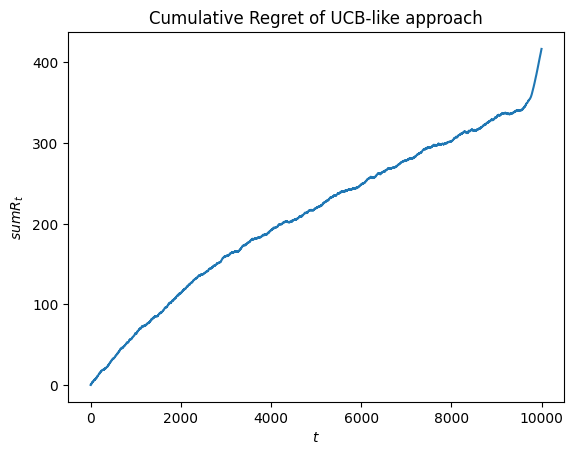

In [12]:
plt.plot(average_regret)
plt.xlabel('$t$')
plt.ylabel('$sum R_t$')
plt.title('Cumulative Regret of UCB-like approach')
plt.show()

Remarks
---

- SUBLINEAR PSEUDO REGRET ACHEIVED
- PSEUDO REGRET OF $O (T^{2/3}\log T)$ ACHEIVED
- PSEUDO REGRET OF $O (T^{2/3})$ ACHEIVED

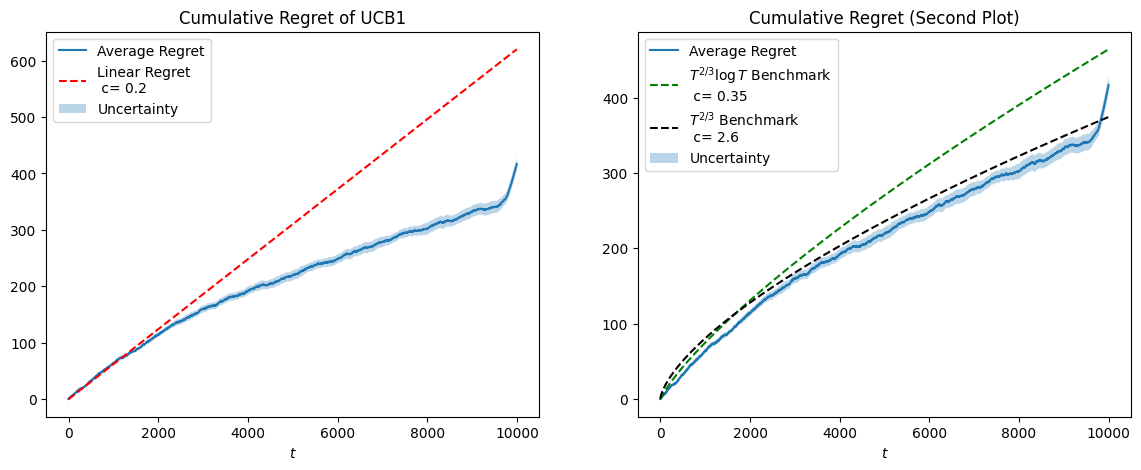

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# First subplot: Cumulative regret with linear line 
axs[0].plot(np.arange(T), average_regret, label='Average Regret')
axs[0].set_title('Cumulative Regret of UCB1')

c_linear = 0.2
linear_regret = np.arange(T) * exp_utility * c_linear # Linear regret line
axs[0].plot(np.arange(T), linear_regret, label='Linear Regret' f'\n c= {c_linear}', linestyle='--', color='red')
axs[0].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)
axs[0].set_xlabel('$t$')
axs[0].legend()

# Second subplot: T^{2/3} benchmark
axs[1].plot(np.arange(T), average_regret, label='Average Regret')
t_vals = np.arange(1, T+1)
c_log = 0.35
benchmark = (t_vals ** (2/3)) * np.log(t_vals) * exp_utility * c_log
axs[1].plot(np.arange(T), benchmark, label=r'$T^{2/3}\log T$ Benchmark' + f'\n c= {c_log}', linestyle='--', color='green')
c_no_log = 2.6
benchmark = (t_vals ** (2/3)) * exp_utility * c_no_log
axs[1].plot(np.arange(T), benchmark, label=r'$T^{2/3}$ Benchmark'+ f'\n c= {c_no_log}', linestyle='--', color='black')

# Fill between for uncertainty in the second plot
axs[1].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)

# Set titles and labels for the second subplot
axs[1].set_title('Cumulative Regret (Second Plot)')
axs[1].set_xlabel('$t$')
axs[1].legend()

plt.show()